# Homework 2
### Danny Hogan

**Code Reuse Note**: Code in this assignment was informed from code within the MLGEO book chapter 2.1 focused on resampling for bootstrapping and LOOCV methodology.

This homework focuses on **resampling** and **noise**.

This homework will explore linear regression and resampling techniques by analysing data from a database of glaciers. The database is *Glatilda* for [*Glacier Ice Thickness Database*](https://www.gtn-g.ch/data_catalogue_glathida/).

1. Data Statistics
2. Data prep (5 points)
2. Mapping (10 points)
3. Correlations between parameters (5 points)
4. Linear regression and resampling techniques (10 points)

## 1. Data Prep (5 points total)

### a) Download data (1 point) 
The database is saved on a GitLab repository that you may clone: https://gitlab.com/wgms/glathida.git



In [1]:
# downloda data
!git clone https://gitlab.com/wgms/glathida.git 

Cloning into 'glathida'...
remote: Enumerating objects: 966, done.
remote: Counting objects: 100% (433/433), done.
remote: Compressing objects: 100% (233/233), done.
remote: Total 966 (delta 233), reused 351 (delta 189), pack-reused 533
Receiving objects: 100% (966/966), 245.07 MiB | 10.74 MiB/s, done.
Resolving deltas: 100% (544/544), done.
Checking out files: 100% (61/61), done.


### b) Import Python modules (1 point) 
Import pandas, geopandas, plotting, raster files,  numpy, netcdf

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rasterio as rio

### c) Read data (2 points)
Read the glacier data from the file ``glathida/data/glacier.csv`` into a pandas data frame, and decribe briefly the dataframe content and its first few lines.

In [126]:
# solution
t_path = "glathida/data/glacier.csv"
glacier_df = pd.read_csv(t_path)
print(glacier_df.columns)
glacier_df.head()

Index(['id', 'survey_id', 'name', 'external_db', 'external_id', 'latitude',
       'longitude', 'date', 'max_date', 'area', 'mean_slope', 'mean_thickness',
       'mean_thickness_uncertainty', 'max_thickness',
       'max_thickness_uncertainty', 'number_points', 'number_profiles',
       'length_profiles', 'interpolation_method', 'flag', 'remarks'],
      dtype='object')


,id,survey_id,name,external_db,external_id,latitude,longitude,date,max_date,area,...,mean_thickness,mean_thickness_uncertainty,max_thickness,max_thickness_uncertainty,number_points,number_profiles,length_profiles,interpolation_method,flag,remarks
0,1,1,Isfallsglaciären,WGI,SE4B000E0006,67.91500,18.56800,1979-03-01,1979-03-31,1.3,...,72.0,NaN,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,Rabots glaciär,WGI,SE4B000E1016,67.91000,18.49600,1979-03-01,1979-03-31,4.1,...,84.0,NaN,175.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN
2,3,1,Storglaciären,WGI,SE4B000E0005,67.90000,18.57000,1979-03-01,1979-03-31,3.1,...,99.0,NaN,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2,South Cascade Glacier,WGI,US2M00264006,48.35698,-121.05735,1975-01-01,1975-12-31,2.0,...,99.0,NaN,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,3,Athabasca Glacier,FOG,7,52.17540,-117.28400,NaN,NaN,3.8,...,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Description**

This dataset provides information on the location and survey dates of different glaciers around the world and what external database that data is taken fromm. There are number of different metrics that are reported to describe the results from the glacier including things like area, mean slope, and thickness, among others.

**Explore the data with visualization**
Before making any inference of models with the data, we will start by exploring basic correlations among parameters by plotting. In particular, we will focus on ``mean_thickness``, ``area``, ``mean_slope`` parameters.

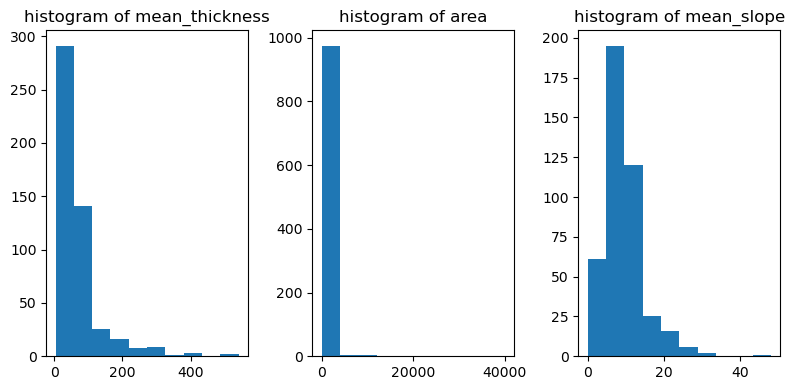

In [3]:
# lets make some simple plots
# first lets make some histograms of our data. I'll just focus on mean_thickness, area, and mean_slope
fig, axs = plt.subplots(1,3, tight_layout=True, figsize=(8,4))
axs = axs.ravel()
col_list = ['mean_thickness', 'area','mean_slope']
for i, col in enumerate(col_list):
    axs[i].hist(glacier_df[col])
    axs[i].set_title(f'histogram of {col}')


glacier_df### d) Remove bad data (1 point)

The database may contain Nans and other "bad" values (welcome to the data world!). First we will clean the data by removing nans. We are mostly interested in the thickness, area, and slope

In [4]:
col_list = ['name','latitude','longitude','mean_thickness', 'area','mean_slope']
# create sub_df
sub_df = glacier_df[col_list]
print(f'Pre-filtered shape: {sub_df.shape}')
sub_filtered_df = sub_df.dropna().reset_index(drop=True)
print(f'Post-filtered shape: {sub_filtered_df.shape}')


Pre-filtered shape: (1012, 6)
Post-filtered shape: (110, 6)


## 2. Mapping glaciers (10 points)

Make a global map of the glaciers. Use either of the tools we learned in class:
* Geopandas, DEMs from NetCDFfiles (see chapter 2.4)
* Pandas and Plotly (see chapter 2.2). You may need to transform some of the series into log-spaced values for better visualization.

### Option 1: Tif and matplotlib

You can use the ``elevation`` data from the DEM seen in class. Download the DEM file (https://www.dropbox.com/s/j5lxhd8uxrtsxko/HYP_50M_SR.tif?dl=1)

In [5]:
# solution


___Tips___: when plotting a image in ``matplotlib`` you need to add information about the physical dimensions of the image. You can calculate the ``bounds``.

In [6]:
bounds = (elevation.bounds.left, elevation.bounds.right, \
          elevation.bounds.bottom, elevation.bounds.top)

We will use ``matplotlib.pyplot`` to show the raster image in the background (tips: use ``imshow()``. The raster image in matplotlib can only import one frame and not three (R, G, B) frames. We will first stack the three images together. 

In [7]:
red = elevation.read(1)
green = elevation.read(2)
blue = elevation.read(3)
pix = np.dstack((red, green, blue))

## Option 2: Plotly

You may use plotly. For improved visibility, transform some of the data into log-spaced. You may add these transformed Series into the Pandas, and use them as input to plotly.

In [8]:

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'vscode' # writes as standalone html, 
# pio.renderers.default = 'iframe' # writes files as standalone html, 
# pio.renderers.default = 'png' # writes files as standalone html, 
# try notebook, jupyterlab, png, vscode, iframe

In [9]:
sub_filtered_df['log_area'] = np.log(sub_filtered_df['area']).astype(int)
sub_filtered_df['norm_log_area'] = 100*(sub_filtered_df['log_area'] - sub_filtered_df['log_area'].min())/(sub_filtered_df['log_area'].max() - sub_filtered_df['log_area'].min())

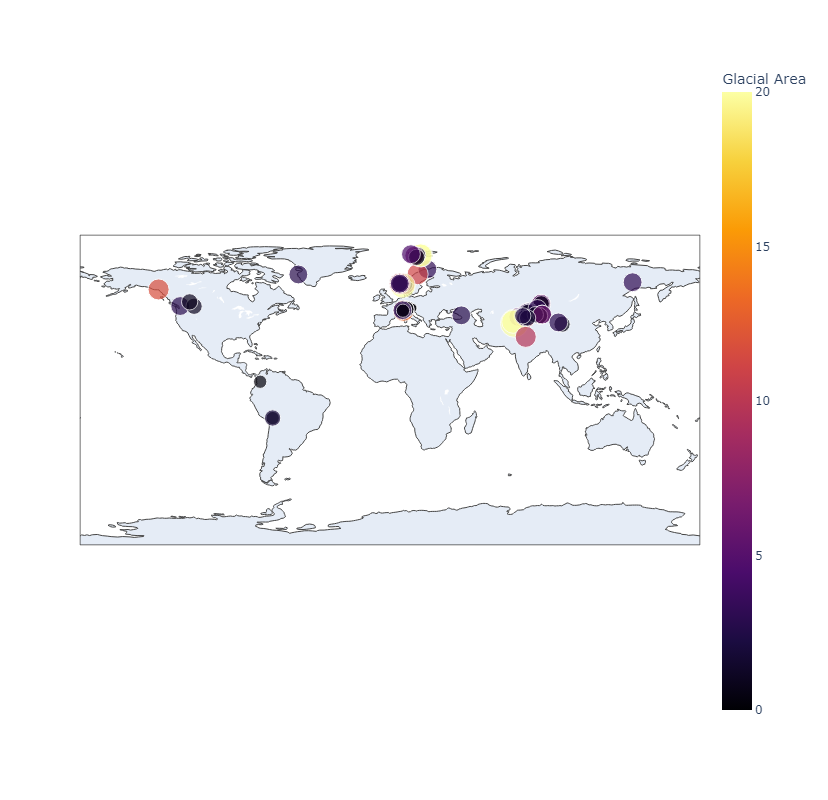

In [10]:
# solution
# range of values for colorbar
vals = [0,5,10,15,20,25]
fig = px.scatter_geo(sub_filtered_df,
                     lat='latitude',lon='longitude', 
                     range_color=(0,20),
                     height=800, width=800,
                     size='norm_log_area',
                     color='area',
                     color_continuous_scale='Inferno',
                     hover_name="name",
                     hover_data=['mean_thickness','area','mean_slope']);

fig.update_layout(coloraxis_colorbar=dict(
    title="Glacial Area",
))
fig.show()

sub_filtered_df## 3. Correlations between data parameters ( 5 points total)

Make plots to vizualise the correlation, or lack of, between all three data. Make at least three plots.

### a) Basic correlations using Matplotlib (2 points)

Make 3 plots using matplotlib to visualize slope, mean_thickness, and area. Use logscale to see the correlatons.

__Tips__: 
* Use the function ``scatter`` to plot the values of mean thickness, mean slope, area, and latitude. 
* use one of the dataframe columns as a color using the argument ``c``. You can also vary the ``colormap`` using the argument ``cmap``. Help on colormaps can be found here: https://matplotlib.org/stable/tutorials/colors/colormaps.html. Be mindful of Color-Vision Deficient readers and read *Crameri, F., Shephard, G.E. and Heron, P.J., 2020. The misuse of colour in science communication. Nature communications, 11(1), pp.1-10. https://doi.org/10.1038/s41467-020-19160-7* (find it on the class Gdrive). You can add a third "data" by choosing a marker color that scales with an other parameter. For instance, try coloring your marker with the ``LAT`` parameter to look at systematic latitudinal trends from the equator to the poles.
* Do not forget to adjust fontsize, figure size (at least 10,8), grid, labels with  of the features (example: km). ou may also explore the *logarithmic* correlations by mapping the axis from linear to logarithmic scale ``plt.xscale('log')``.

/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log



Text(0, 0.5, 'log(mean_slope)')

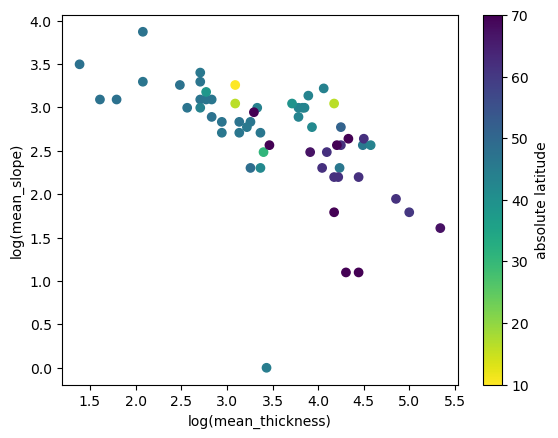

In [11]:
# Figure 1: Mean slope vs mean thickness
# solution
sub_filtered_df['log_mean_thickness'] = np.log(sub_filtered_df['mean_thickness'])
sub_filtered_df['log_area'] = np.log(sub_filtered_df['area'])
sub_filtered_df['log_mean_slope'] = np.log(sub_filtered_df['mean_slope'])
plt.scatter(sub_filtered_df['log_mean_thickness'],
            sub_filtered_df['log_mean_slope'], 
            c=np.abs(sub_filtered_df['latitude']),
            vmin=10,
            vmax=70,
            cmap='viridis_r')
plt.colorbar(label='absolute latitude')
plt.xlabel('log(mean_thickness)')
plt.ylabel('log(mean_slope)')

Text(0, 0.5, 'log(mean_area)')

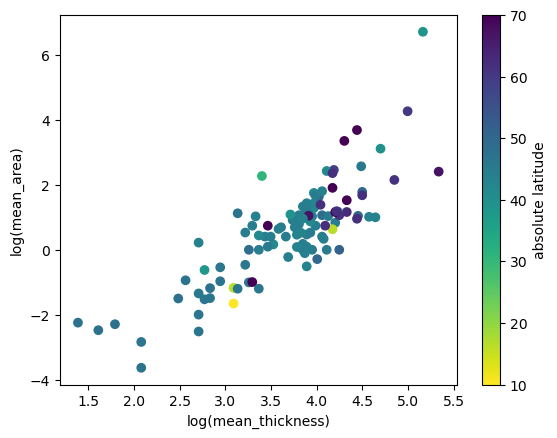

In [12]:
# Figure 2: area vs mean thickness
# solution
plt.scatter(np.log(sub_filtered_df['mean_thickness']),
            np.log(sub_filtered_df['area']), 
            c=np.abs(sub_filtered_df['latitude']),
            vmin=10,
            vmax=70,
            cmap='viridis_r')
plt.colorbar(label='absolute latitude')
plt.xlabel('log(mean_thickness)')
plt.ylabel('log(mean_area)')

### b) 3D Scatter plot using Plotly (1 point)

Use the plotly ``scatter_3d`` plot. Make sure to change the pandas series for log scales.

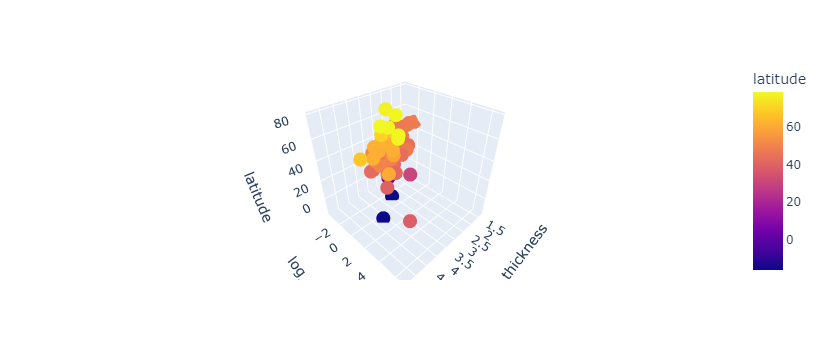

In [13]:
# solution
# use plotly to create a 3d scatter plot of thickness, area, and latitude
px.scatter_3d(
    data_frame=sub_filtered_df,
    x='log_mean_thickness',
    y='log_area',
    z='latitude',
    color='latitude',
)
    

### c) Pandas Correlation function (1 point)

You may use Pandas functionalities to explore correlation between data. Use the function ``corr`` on the dataframe and the matplotlib function ``matshow`` to plot a heatmap of the correlations

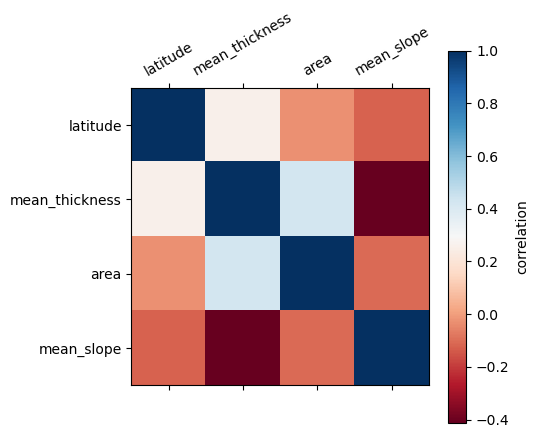

In [32]:
#solution
cols = ['latitude','mean_thickness','area','mean_slope']
glacier_df_corr = sub_filtered_df[cols].corr()
plt.matshow(glacier_df_corr, cmap='RdBu')
plt.xticks(ticks=[0,1,2,3],labels=cols,rotation=30, ha='center')
plt.yticks(ticks=[0,1,2,3],labels=cols,rotation=0)
plt.colorbar(label='correlation')

### f) Seaborn Plotting (1 point)

Seaborn is a great python package for basic data anlytics. See documentation [here](!https://seaborn.pydata.org/). You can visualize the data by plotting data features against each other and explore visually data correlations.

<AxesSubplot: >

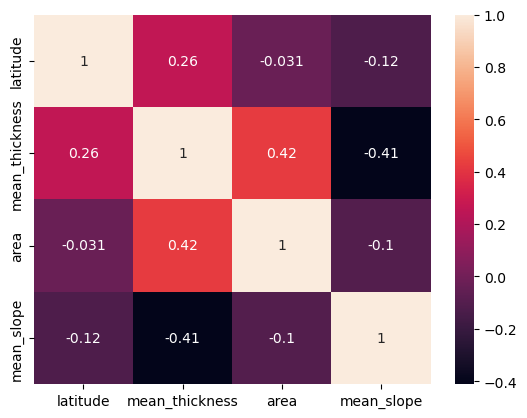

In [34]:
# solution
import seaborn as sns
# plot heatmap with seaborn and label values
sns.heatmap(glacier_df_corr, annot=True)



Discuss the basic correlations among the data. Do these correction make sense when you think about the shapes of glaciers?

Here, we see that thickness and slope are somewhat negatively correlated, while area and thickness are somewhat positively correlated. Thickness and latitude are also somewhat positively correlated.

We would expect these relationships because:
1) a steep slope would imply that the glacial ice would flow faster towards its terminous, leaving less time for the ice thickness to build up;
2) a larger glacier that covers a larger area would be expected to have a lot more ice to maintain the larger footprint, so the mean thickness would be expected to be greater;
3) with cooler temperatures at higher latitudes, glaciers would be expected to grow thicker than glaciers at lower latitudes with warmer temperatures.

## 4. Linear Regression (10 points total counted in the next section)
You found from basic data visualization that the three parameters ``mean_slope``, ``mean_thickness``, and ``area`` are correlated. It does make physical sense because a *steep* glaciers is likely to be in the high mountains regions, hanging on the mountain walls, and thus be constrained, and conversely, a flat glacier is either at its valley, ocean terminus or on ice sheets.

### a) Simple linear regression (2 points)
We will now perform a regression between the parameters (or their log!). Linear regressions are models that can be imported from scikit-learn. Log/exp functions in numpy as ``np.log()`` and ``np.exp()``.
Remember that a linear regression is finding $a$ and $b$ knowing both $x$ and the data $y$ in $y = Ax +b$. We want to predict ice thickness from a crude estimate of the glacier area.

__Tips__: 
a. make sure that the dimensions are correct and that there is no NaNs and zeros.
b. Make sure to inport the scikit learn linear regression function and the error metrics.

In [37]:
# solution
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



Make a plot of the data and the linear regression your performed

Coefficients: 
 [[0.27462361]]
Mean squared error: 0.24
Coefficient of determination: 0.57


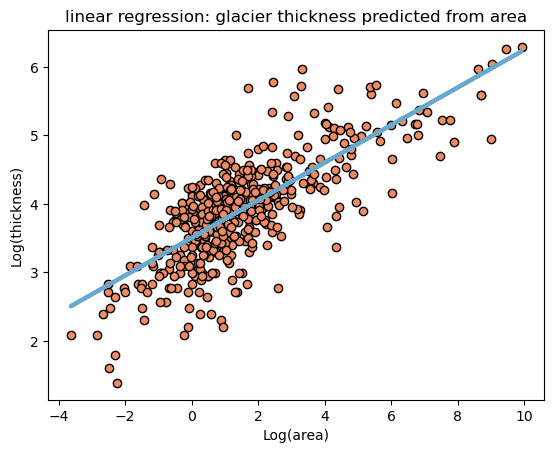

In [77]:
# solution
# Grab the data i want and drop nans
thickness_area_df = glacier_df[['mean_thickness','area']].dropna()
# save the two columns i want to build me regression from
# to avoid an error, need to add double brackets
X = np.log(np.asarray(thickness_area_df['area'])).reshape(-1, 1)
y = np.log(np.asarray(thickness_area_df['mean_thickness'])).reshape(-1, 1)
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

# Make predictions using the testing set
y_pred = regr.predict(X)

plt.scatter(X,y, ec='k', color='#ef8a62')
plt.plot(np.sort(X),np.sort(y_pred), lw='3', color='#67a9cf')
plt.xlabel('Log(area)')
plt.ylabel('Log(thickness)')
plt.title('linear regression: glacier thickness predicted from area')


# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))


**Briefly comment on the quality of your fit and a linear regression (1 point)**

The fit looks okay, except outliers on either end seem to really define the regression. Additionally, there is quite a bit of spread around the line throughout the middle of the data

### b) Leave One Out Cross Validation linear regression (1 point)


Perform the LOCCV on the ``area`` and ``thickness`` values. Predict the ``thickness`` value knowing a ``area`` value. Use material seen in class. Make a plot of your fit.

mean of the slope estimates 0.2746244.2 and the standard deviation 0.0005124.2
CV = 0.24


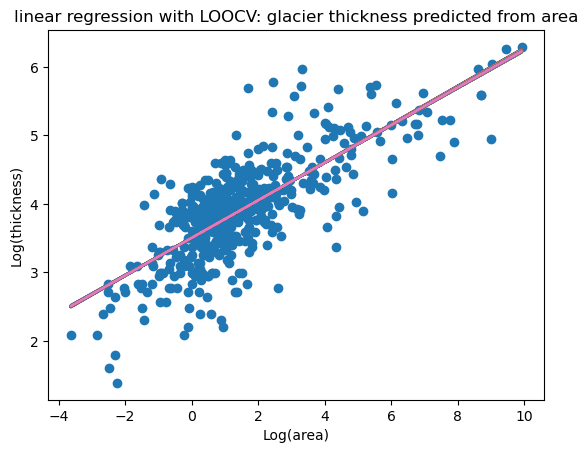

In [174]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

slope = np.zeros(len(X)) # initalize a vector to store the regression values
mse_train = np.zeros(len(X))
mse_val = np.zeros(len(X))
fig, ax = plt.subplots()
ax.scatter(X,y)
i=0
for train_index, test_index in loo.split(X):    
    # split into train and test sets for LOO
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(X_train,y_train)
    # We will first predict the fit:
    ypred_train=regr.predict(X_train) 
    ypred_val=regr.predict(X_val) 
    
    # plot the line
    ax.plot(X_train,ypred_train)
    # The coefficients
    slope[i]= regr.coef_[0][0]
    mse_train[i]= mean_squared_error(y_train, ypred_train)
    mse_val[i]= mean_squared_error(y_val, ypred_val)
    i+=1
plt.xlabel('Log(area)')
plt.ylabel('Log(thickness)')
plt.title('linear regression with LOOCV: glacier thickness predicted from area')
print("mean of the slope estimates %f4.2 and the standard deviation %f4.2"%(np.mean(slope),np.std(slope)))
# the test error is the average of the mean-square-errors
print("CV = %4.2f"%(np.mean(mse_val)))

### c) Bootstrapping (1 point)

Perform the same analysis but using a bootstrapping technique. Output the mean and standard deviation of the slope. An illustration with a histogram  may help.

In [135]:
from sklearn.utils import resample
# solution

k=100
slope = np.zeros(len(X)) # initalize a vector to store the regression values
mse = np.zeros(len(X))
r2s = np.zeros(len(X))
i=0
for i,val in enumerate(X):    
    ii = resample(np.arange(len(X)),replace=True,n_samples=len(X))# new indices
    X_b, y_b = X[ii], y[ii]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(X_b,y_b)
    ypred_val=regr.predict(X) # test on the validation set.

    # save the coefficients
    slope[i]= regr.coef_[0][0]
    mse = mean_squared_error(y[ii], y_b)
    r2s[i] = r2_score(y, y_b)

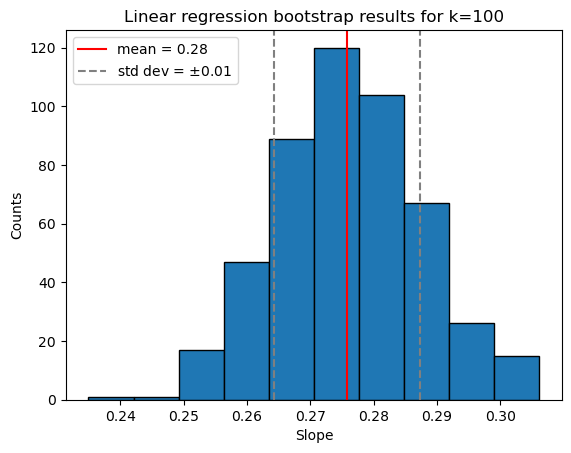

In [136]:
plt.hist(slope, ec='k')
# Plot the mean
plt.axvline(np.mean(slope),color='red', label=f'mean = {np.round(np.mean(slope),2)}')
# Plot standard deviations
plt.axvline(np.mean(slope)+np.std(slope), 
            color='grey', 
            ls='--')
plt.axvline(np.mean(slope)-np.std(slope), 
            color='grey', 
            ls='--', 
            label=f'std dev = $\pm${np.round(np.std(slope),2)}')
plt.xlabel('Slope')
plt.ylabel('Counts')
plt.title(f'Linear regression bootstrap results for k={k}')
plt.legend()

### d) Predict the thickness of a glacier (2 points)

Let assume that you measure a glacier of area 10 km$^2$. Can you use your bootstrap regression framework to provide a distribution of possible values of the ice thickness ? Output the mean and standard deviation of the predicted ice thickness.

In [156]:
# solution
input_val = np.log(10) # input for glacier area
output = np.zeros(len(X)) # initalize a vector to store the regression values
mse = np.zeros(len(X))
r2s = np.zeros(len(X))
i=0
for i,val in enumerate(X):    
    ii = resample(np.arange(len(X)),replace=True,n_samples=len(X))# new indices
    X_b, y_b = X[ii], y[ii]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(X_b,y_b)
    ypred_val=regr.predict(X) # test on the validation set.
    
    # save the output and remove from log space
    slope = regr.coef_[0][0] 
    intercept = regr.intercept_[0]
    output[i] = np.exp(slope*input_val+intercept)
    


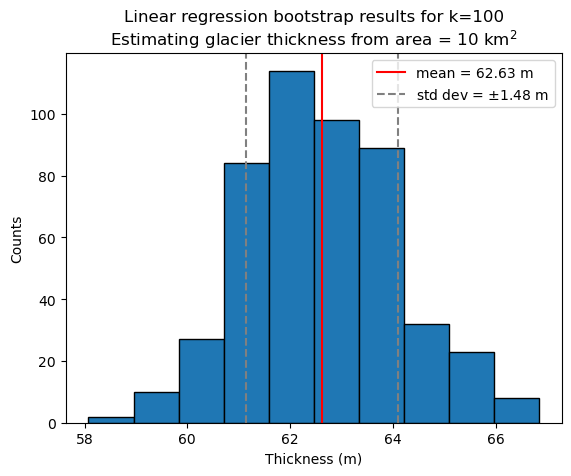

In [161]:
plt.hist(output, ec='k')
# Plot the mean
plt.axvline(np.mean(output),color='red', label=f'mean = {np.round(np.mean(output),2)} m')
# Plot standard deviations
plt.axvline(np.mean(output)+np.std(output), 
            color='grey', 
            ls='--')
plt.axvline(np.mean(output)-np.std(output), 
            color='grey', 
            ls='--', 
            label=f'std dev = $\pm${np.round(np.std(output),2)} m')
plt.xlabel('Thickness (m)')
plt.ylabel('Counts')
plt.title(f'Linear regression bootstrap results for k={k}\nEstimating glacier thickness from area = 10 km$^2$')
plt.legend()